# **Exploratory Data Analysis on Twitter Sentiment Analysis dataset**

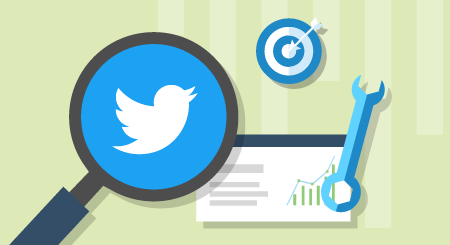

By :  <a href="https://www.linkedin.com/in/bala-murugan-62073b212/">Balamurugan P

# **Introduction**

The task is to squeeze out as much insights as possible from just a single feature (tweets).

The dataset contains tweets categorized as "Offensive (racism/sexism)" labelled as 1 and "Not offensive" labelled as 0.

This dataset contains around 50k tweets split into training and testing data.


Analysis was done using,
* *Different kinds of visualizations like pie chart, bar chart, box plot etc.*
* *Creating Word clouds.*
* *Extracting information from hashtags.*
* *Named Entity Recognition.*

# **Let's import the dependancies**

In [1]:
# Importing modules
import re
import pandas as pd
import spacy
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Setting to use seaborn style for plots
matplotlib.style.use("seaborn")

# **Let's load our data**

In [3]:
# Loading data
train = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/train.csv")
test = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/test.csv")

# **Exploring DataFrames**

*Let's explore some rows of our DataFrames and check their schema.*

In [4]:
# Displaying sample obervations
display(train.head())
display(test.head())

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
# Label encodings
labels = {0: "not offensive", 1: "offensive"}
print(labels)

{0: 'not offensive', 1: 'offensive'}


In [6]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


None

In [7]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


None

* The dataset contains three columns - "id", "label", "tweet"
* Column "id" is not useful for classification.
* Column "tweet" contains the tweets and column "label" contains their category.
* There is no null values.

# **Checking the distribution of categories**

*Let's check how much data falls under each category.*

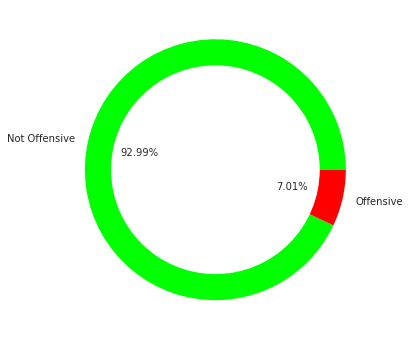

In [8]:
# Visualising distribution of observations among categories

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    train["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not Offensive", "Offensive"],
    colors = ["#00ff00", "#ff0000"]
)

# Creates circle
circle = plt.Circle((0,0), 0.80,fc='white')

# Adds circle object to the existing figure (pie chart)
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()

* Offensive tweets which reflects racism or sexism are relatively lesser in number.
* Due to this class imbalance, Accuracy may not be a good option for checking performance of our models. Instead, confusion matrix can be a good option.

# **Now, we can have a look at length of each tweets**

*Knowing the max number of words in the dataset will be helpful later.*

[Text(0.5, 0, '( Number of Tokens )'),
 Text(0, 0.5, '( Number of Observations )')]

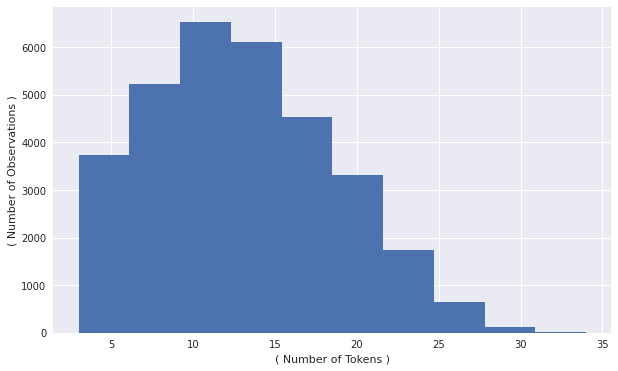

In [9]:
# Plotting histogram for number of tokens in each observation
ax1 = train.tweet.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
ax1.set(xlabel="( Number of Tokens )", ylabel="( Number of Observations )")

* Most of the tweets have around 5 to 20 tokens.

*Let's look a bit deeper.*

Text(0, 0.5, '( Number of Tokens )')

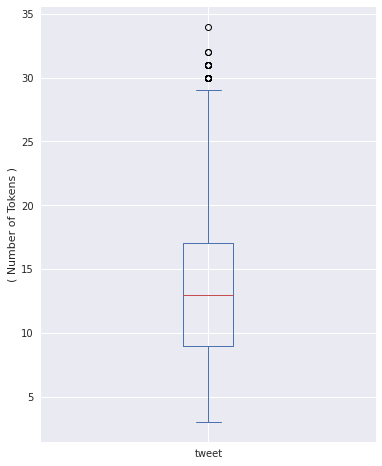

In [10]:
# Plotting boxplot for number of tokens in each observation
ax2 = train.tweet.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
ax2.set_ylabel("( Number of Tokens )")

* The number of tokens between 25th and 75th %ile (Interquartile range) of data ranges from 9 to 17 tokens, median being 13 tokens.
* Max length of any tweet in the dataset is less than 35 tokens.

# **Preprocessing tweets and creating word corpus**

*Word corpus is helpful for analysing data and useful for Named entity recognition, creating word clouds etc...*

In [11]:
def preprocess_tweets(df_series):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        
    Returns: 
        df_series (pd.series): Preprocessed series object. 
    """
    
    # Removes '@user' tags
    df_series = df_series.str.replace("@user", "", regex=False)
    
    # Removes non alphanumeric characters
    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    return df_series
    

def tokenize(sentence, remove_stopwords=False):
    """ Tokenizes given sentence.
        
    Args:
        sentence (str): Sentence to be tokenized
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        tokens (list): Tokenized array
    """
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = sentence.split()
        tokens = [token for token in tokens if not token.lower() in stop_words]
        return tokens
        
    return sentence.split()
    

def create_corpus(df_series, remove_stopwords=False):
    """ Creates preprocessed, lemmatized word corpus from pandas series.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        corpus (list): Tokenized, Lemmatized word corpus. 
    """
    
    corpus = []
    lm = WordNetLemmatizer()
    df_series = preprocess_tweets(df_series)
    
    for tweet in df_series:
        corpus.extend([lm.lemmatize(word) for word in tokenize(tweet, remove_stopwords=remove_stopwords)])
    
    return corpus
    

offensive_corpus = create_corpus(train[train["label"]==1].tweet, remove_stopwords=True)
non_offensive_corpus = create_corpus(train[train["label"]==0].tweet, remove_stopwords=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


# **Creating word cloud from our corpus**

*Word cloud shows the highly frequent words*

In [12]:
def plot_word_cloud(corpus):
    """ Creates and plots the word cloud from word corpus.
        
    Args:
        corpus (list): word corpus containing all the tokens.
        
    Returns: Nothing
    
    """
    
    # creates word cloud
    word_cloud = WordCloud(
        max_words = 100,
        max_font_size = 50,
        collocations = False
    ).generate(str(corpus))
    
    # plots word cloud
    fig = plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()

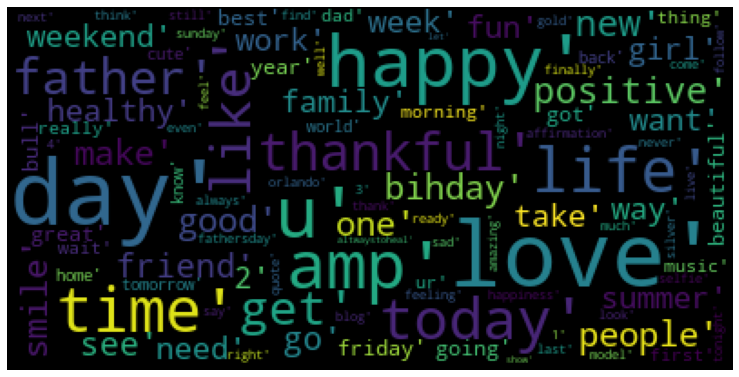

In [13]:
# Word cloud of non-offensive tokens
plot_word_cloud(non_offensive_corpus)

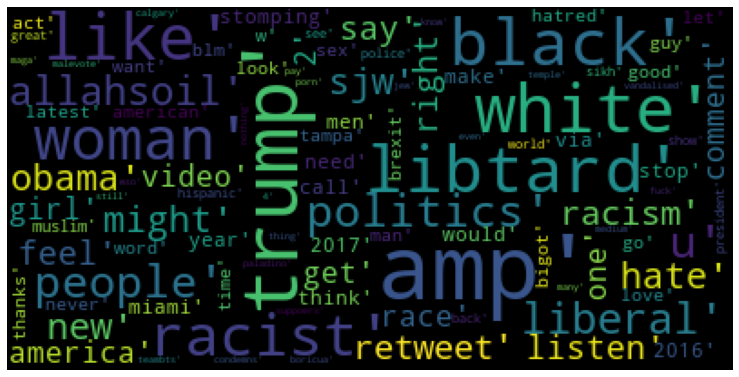

In [14]:
# Word cloud of offensive tokens
plot_word_cloud(offensive_corpus)

* We can clearly see the words like "racist", "black", "hate", "race" which reflects offensiveness. Which were not present in the case of non-offensive corpus.

# **Finding named entity for all the words in our tweets data**

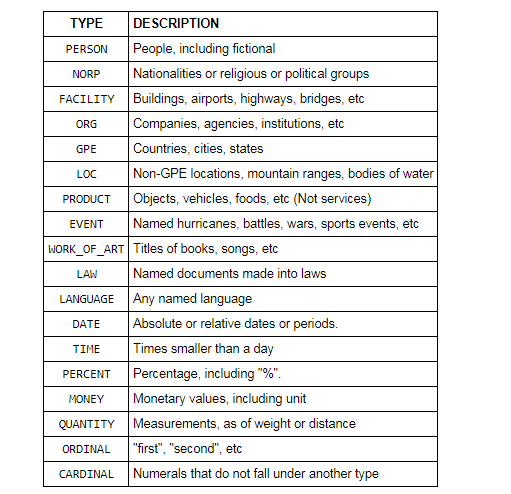

*To check what the offensive and non-offensive tweets talks about the most*

In [15]:
def create_ner_dict(df_series):
    """ Creates and returns dictionary having text phrases and their named entity.
    
    Args:
        df_series (pd.series): Pandas series object containing sentences.
    
    Returns:
        NER_dict (dict): Dictionary of text phrases from sentences of df_series and 
                         corresponding named entities.
    """
    
    NER = spacy.load("en_core_web_sm")
    NER_dict = {"text": [], "named_entity":[]}
    
    # Preprocessing tweets
    preprocessed_tweets = preprocess_tweets(df_series)
    
    # Removing stop words and creating named entity recognition dict
    for tweet in preprocessed_tweets:
        sentence = tokenize(tweet, remove_stopwords=True)
        sentence = ' '.join(map(str, sentence))
        doc = NER(sentence)
        NER_dict["text"].extend([token.text for token in doc.ents])
        NER_dict["named_entity"].extend([token.label_ for token in doc.ents])
        
    return NER_dict

In [16]:
# Named entity recognition of tweets of different categories
non_offensive_NER_dict = create_ner_dict(train[train["label"]==0].tweet)
offensive_NER_dict = create_ner_dict(train[train["label"]==1].tweet)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


In [17]:
# Converting to DataFrame
non_offensive_NER_df = pd.DataFrame.from_dict(non_offensive_NER_dict)
offensive_NER_df = pd.DataFrame.from_dict(offensive_NER_dict)

In [18]:
# Displaying sample observations
display(non_offensive_NER_df.head())
display(offensive_NER_df.head())

,text,named_entity
0,wheelchair vans pdx,ORG
1,bihday majesty,PERSON
2,2 2,CARDINAL
3,tomorrow,DATE
4,next school year year,DATE


,text,named_entity
0,cnn,ORG
1,michigan middle school,ORG
2,lumpy,ORG
3,21st century,DATE
4,blk folx,PERSON


# **Visualizes frequency of each named entities in our data**

<AxesSubplot:ylabel='named_entity'>

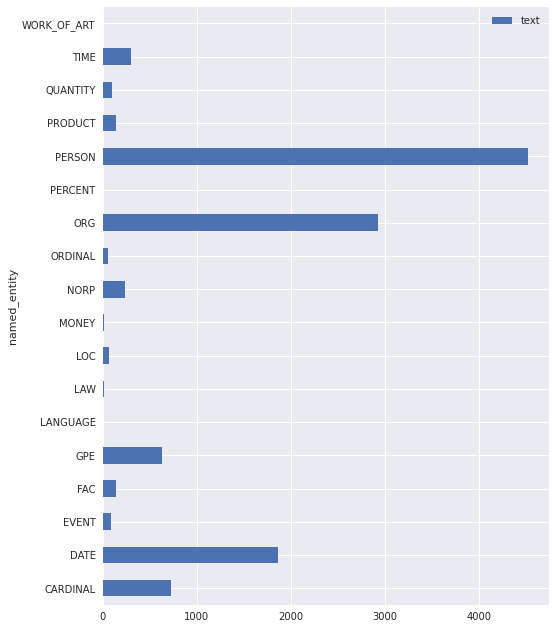

In [19]:
# Plotting named entities mentioned most times in Non-Offensive tweets
non_offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

<AxesSubplot:ylabel='named_entity'>

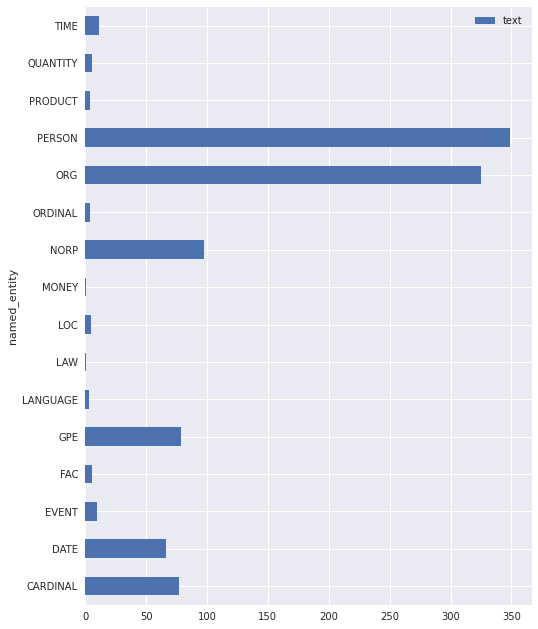

In [20]:
# Plotting named entities mentioned most times in Offensive tweets
offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

* From the visualisation we can infer that most of the times tweets are about a specific person or an organisation.
* Offensiveness in tweets also targets a specific person, organisation, nationalities, religious or political groups.

# **Finding most repeated text phrases under each named entity**

*Let's find and visualize highly frequent text phrases grouped by each named entity.*

In [21]:
# Creates new df containing count of text by each named entity of Non offensive tweets
non_offensive_NER_text_occurances = non_offensive_NER_df.groupby("named_entity").agg({"text": list})
non_offensive_NER_text_occurances["text_counts"] = non_offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [22]:
display(non_offensive_NER_text_occurances)

,text,text_counts
named_entity,,
CARDINAL,"[2 2, 0 2, 50, 1, one, 2, 15, 7 99, 1 1400, on...","{'2 2': 3, '0 2': 7, '50': 64, '1': 129, 'one'..."
DATE,"[tomorrow, next school year year, today 80days...","{'tomorrow': 357, 'next school year year': 1, ..."
EVENT,"[bihday 21thbihday, 3rd year, sun day, olympic...","{'bihday 21thbihday': 1, '3rd year': 2, 'sun d..."
FAC,"[bihday petunia, guys kiss gay, spring street,...","{'bihday petunia': 1, 'guys kiss gay': 1, 'spr..."
GPE,"[cleveland, ireland, nohern ireland, gawa, pol...","{'cleveland': 17, 'ireland': 10, 'nohern irela..."
LANGUAGE,"[english, english, english, english, english, ...","{'english': 24, 'thebarn1934': 1, '4wd': 1, '4..."
LAW,"[ffxiv, 1st w tweet, reminders months amp, 1st...","{'ffxiv': 1, '1st w tweet': 1, 'reminders mont..."
LOC,"[weston, europe, europe, river island, africa,...","{'weston': 1, 'europe': 19, 'river island': 1,..."
MONEY,"[70 bucks, 10 cents, 151, 101 encinitas, mr ye...","{'70 bucks': 1, '10 cents': 1, '151': 1, '101 ..."


In [23]:
# Creates new df containing count of text by each named entity of Offensive tweets
offensive_NER_text_occurances = offensive_NER_df.groupby("named_entity").agg({"text": list})
offensive_NER_text_occurances["text_counts"] = offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [24]:
def sort_dict_by_value(dictionary, reverse=False):
    """ Returns list of (value, key) tuples sorted by value.
    
    Args:
        dictionary (dict): Dict of key, value pairs.
        reverse (bool): Sorts in descending order if set True. Defaults to False
        
    Returns:
        list: Contains (value, key) tuples sorted by value
    """
    
    return sorted(
        dict((value, key) for (key, value) in dictionary.items()).items(),
        reverse=reverse
    )


def max_val_of_dict(dictionary):
    """ Returns list containing maximum value and its corresponding 
        key in a dict.
        
    Args:
        dictionary (dict): Dict of key, value pairs.
            
    Returns:
        list: Contains corresponding key of maximum value in the dictionary
              and the maximum value itself.
    """
    
    max_key = max(dictionary, key=dictionary.get)
    max_value = dictionary[max_key]
    
    return [max_key, max_value]

In [25]:
# displays highest repeated text by each named entity in Non offensive tweets
n_rows, n_cols = non_offensive_NER_text_occurances.shape

for i in range(n_rows):
    non_offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                non_offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

non_offensive_NER_text_occurances.reset_index(inplace=True)
display(non_offensive_NER_text_occurances)

,named_entity,text,text_counts
0,CARDINAL,"[2 2, 0 2, 50, 1, one, 2, 15, 7 99, 1 1400, on...","[(483, one), (276, 2), (184, 3), (155, 4), (12..."
1,DATE,"[tomorrow, next school year year, today 80days...","[(883, today), (449, friday), (357, tomorrow),..."
2,EVENT,"[bihday 21thbihday, 3rd year, sun day, olympic...","[(5, new week), (4, great day), (3, new day), ..."
3,FAC,"[bihday petunia, guys kiss gay, spring street,...","[(4, broadway), (3, blue shark), (2, 65th stre..."
4,GPE,"[cleveland, ireland, nohern ireland, gawa, pol...","[(182, orlando), (110, london), (85, america),..."
5,LANGUAGE,"[english, english, english, english, english, ...","[(24, english), (2, spanish), (1, 3months)]"
6,LAW,"[ffxiv, 1st w tweet, reminders months amp, 1st...","[(2, loveher holiday), (1, 1st 11)]"
7,LOC,"[weston, europe, europe, river island, africa,...","[(19, europe), (7, asia), (4, africa), (2, wes..."
8,MONEY,"[70 bucks, 10 cents, 151, 101 encinitas, mr ye...","[(2, 101 encinitas), (1, 16 puppy)]"
9,NORP,"[japanese, muslim, republicans, christians, am...","[(34, americans), (31, american), (22, muslim)..."


In [26]:
# displays highest repeated text by each named entity in Offensive tweets
n_rows, n_cols = offensive_NER_text_occurances.shape

for i in range(n_rows):
    offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

offensive_NER_text_occurances.reset_index(inplace=True)

display(offensive_NER_text_occurances)

,named_entity,text,text_counts
0,CARDINAL,"[one finger millions, 7, 75, one, 60, 25, 2, o...","[(39, 2), (35, one), (18, 4), (10, 5), (7, 8),..."
1,DATE,"[21st century, 2016, next week, endof2016, 8 y...","[(31, 2016), (26, 2017), (12, daily), (10, tod..."
2,EVENT,"[new year, new year, new year eve, american re...","[(8, new year), (3, allahsoil cold war fought)..."
3,FAC,"[soros groups threaten public safety, nye twee...","[(1, kentucky mall)]"
4,GPE,"[us, us, pittsburgh, city berlin, america, isr...","[(37, miami), (34, america), (26, calgary), (2..."
5,LANGUAGE,"[english, english, spanish, arabic]","[(2, english), (1, arabic)]"
6,LAW,"[14th amendment, 14th amendment]","[(2, 14th amendment)]"
7,LOC,"[europe, africa, africa, asia, lpc canpoli, eu...","[(3, europe), (2, mars), (1, lpc canpoli)]"
8,MONEY,"[multi million dollar, multi million dollar]","[(2, multi million dollar)]"
9,NORP,"[republican, african american, nazi, nazis, am...","[(29, hispanic), (19, americans), (12, republi..."


In [27]:
# These are the named entities that we want to explore further
req_entities = ["EVENT", "GPE", "LANGUAGE", "NORP", "ORG"]
n_req_entities = len(req_entities)

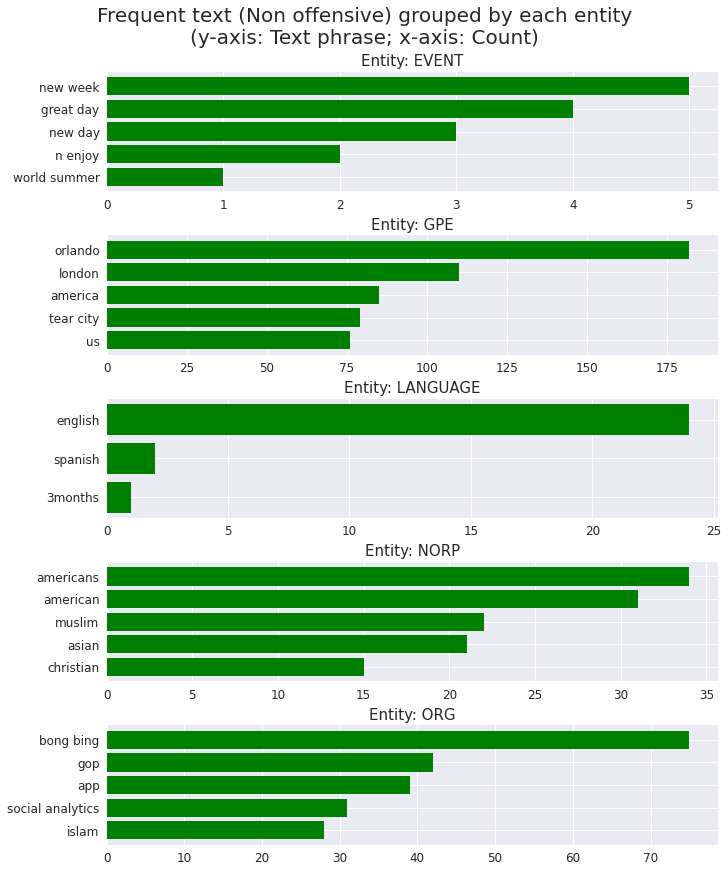

In [28]:
# Visualizes most repetetive Non offensive text phrases from each named entity
fig1, ax3 = plt.subplots(n_req_entities, constrained_layout=True, figsize=(10, 12))
fig1.suptitle("Frequent text (Non offensive) grouped by each entity\n(y-axis: Text phrase; x-axis: Count)", fontsize=20)

for i in range(n_req_entities):
    x, yticklabels = list(zip(
                        *non_offensive_NER_text_occurances[non_offensive_NER_text_occurances["named_entity"] == req_entities[i]]["text_counts"].values[0][:5]))
    ax3[i].barh(yticklabels, x, color='green')
    ax3[i].set_title("Entity: " + req_entities[i], fontsize=15)
    ax3[i].tick_params(labelsize=12)
    ax3[i].invert_yaxis()

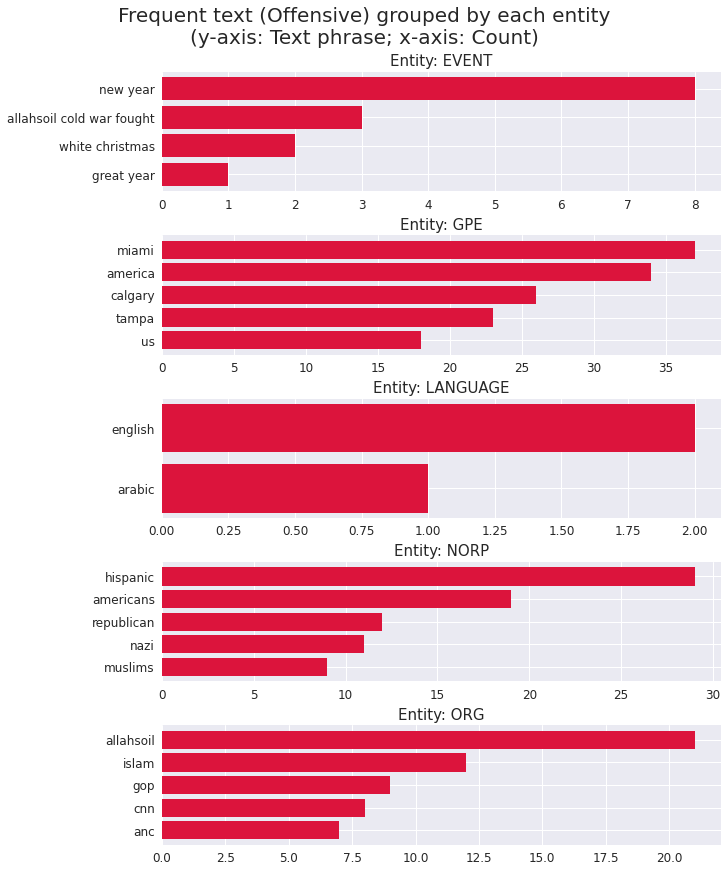

In [29]:
# Visualizes most repetetive Offensive text phrases from each named entity
fig2, ax4 = plt.subplots(n_req_entities, constrained_layout=True, figsize=(10, 12))
fig2.suptitle("Frequent text (Offensive) grouped by each entity\n(y-axis: Text phrase; x-axis: Count)", fontsize=20)

for i in range(n_req_entities):
    x, yticklabels = list(zip(
                        *offensive_NER_text_occurances[offensive_NER_text_occurances["named_entity"] == req_entities[i]]["text_counts"].values[0][:5]))
    ax4[i].barh(yticklabels, x, color='crimson')
    ax4[i].set_title("Entity: " + req_entities[i], fontsize=15)
    ax4[i].tick_params(labelsize=12)
    ax4[i].invert_yaxis()

* From the visualisations we can see the most frequent words grouped by each named entity across categories.

# **Visualizing top mentioned hashtags under each category**

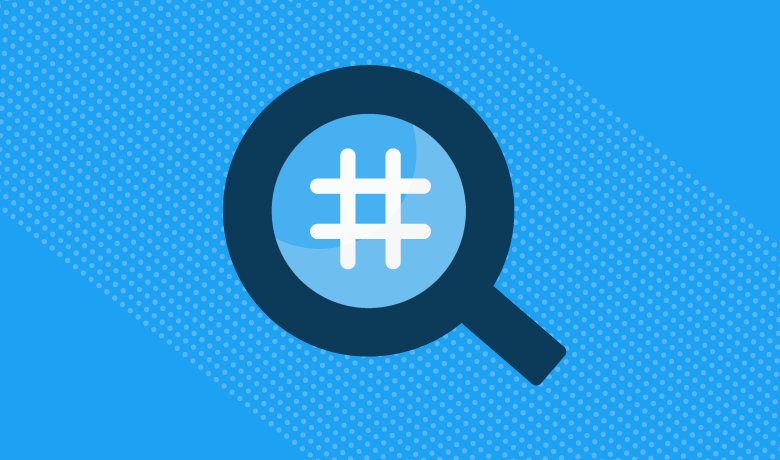

*Hashtags always hold some meaningful insights. They mostly express the essence of the whole tweet in one word or denotes the person or place or something about which the tweet talks about.*

In [30]:
def get_hash_tags(df_series):
    """ Collects all hash tags from a given pandas series.
    
    Args:
        df_series (pd.Series): Pandas series object containing text data.
    
    Returns:
        hash_tags (list): List of hash tags from the pandas series.
    """
    
    hash_tags = []
    for text in df_series:
        hash_tags.extend(re.findall(r'#(\w+)', text))
        
    return hash_tags

In [31]:
non_offensive_hashtags = get_hash_tags(train[train["label"]==0]["tweet"])
offensive_hashtags = get_hash_tags(train[train["label"]==1]["tweet"])

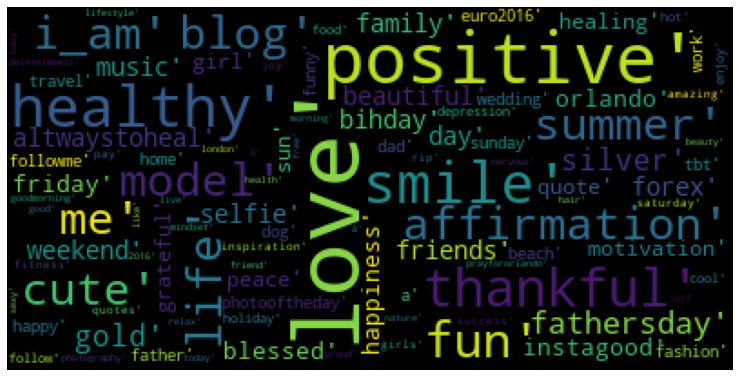

In [32]:
# Word cloud of top mentioned hashtags in Non-offensive tweets
plot_word_cloud(non_offensive_hashtags)

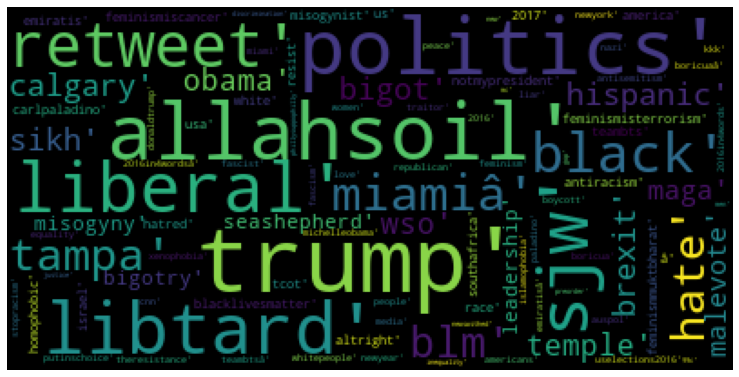

In [33]:
# Word cloud of top mentioned hashtags in Offensive tweets
plot_word_cloud(offensive_hashtags)

In [34]:
# Count of each hashtags
non_offensive_hashtag_counts = Counter(non_offensive_hashtags)
offensive_hashtag_counts = Counter(offensive_hashtags)

In [35]:
# Creating hashtag counts DataFrame for easy manipulation and visualization

non_offensive_hashtag_counts_df = pd.DataFrame.from_dict(non_offensive_hashtag_counts, orient="index").reset_index()
non_offensive_hashtag_counts_df.columns = ["hashtag", "count"]
non_offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(non_offensive_hashtag_counts_df.head())

offensive_hashtag_counts_df = pd.DataFrame.from_dict(offensive_hashtag_counts, orient="index").reset_index()
offensive_hashtag_counts_df.columns = ["hashtag", "count"]
offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(offensive_hashtag_counts_df.head())

,hashtag,count
33,love,1531
41,positive,874
163,healthy,570
212,smile,548
40,thankful,491


,hashtag,count
22,trump,133
31,politics,94
67,allahsoil,92
28,libtard,76
30,liberal,75


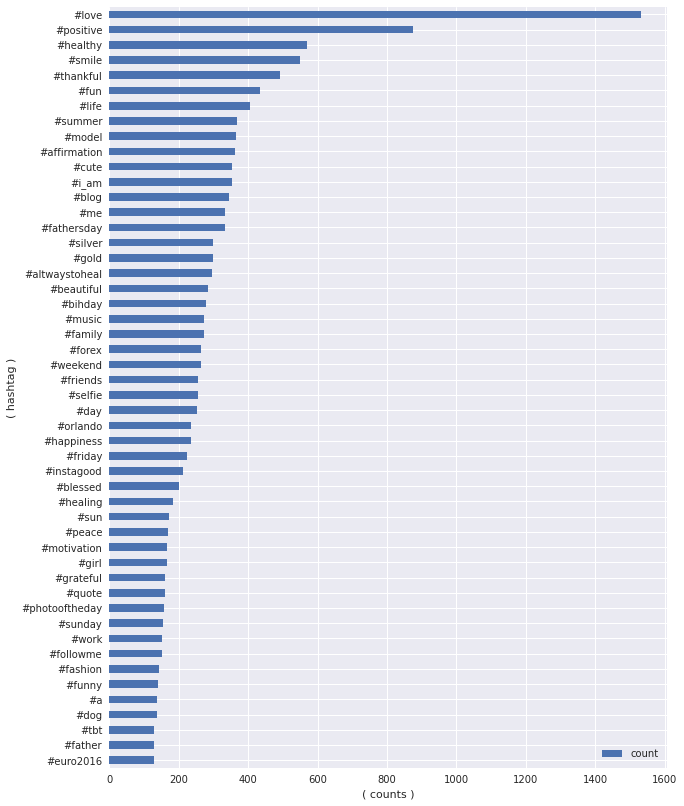

In [36]:
# Bar plot of top hashtag counts in Non-offensive tweets 
ax5 = non_offensive_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14))
ax5.set(xlabel="( counts )", ylabel="( hashtag )")
ax5.set_yticklabels(non_offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax5.invert_yaxis()
plt.show()

* The Above visualisation shows the most frequent hashtags which were present in non-offensive tweets.

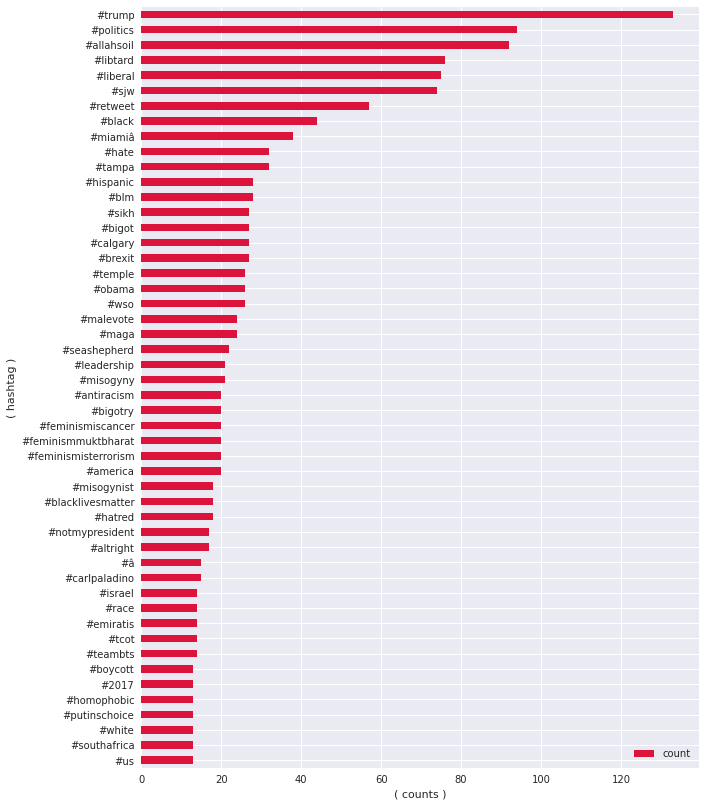

In [37]:
# Bar plot of top hashtag counts in Offensive tweets 
ax6 = offensive_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14), color="crimson")
ax6.set(xlabel="( counts )", ylabel="( hashtag )")
ax6.set_yticklabels(offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax6.invert_yaxis()
plt.show()

* The Above visualisation shows the most frequent hashtags which were present in offensive tweets.

# **What proportion of tweets contains a hashtag?**

*We can even use just hashtags to classify our tweets. Even a piece of data matters a lot.*

In [38]:
def count_rows_with_hashtag(df_series):
    """ Counts the number of rows containing at least one hashtag (#example).
    
    Args:
        df_series (pd.Series): Pandas series containing text data.
        
    Returns:
        count (int): Count of number of rows containing at least one hashtag.
    """
    
    count = 0
    for tweet in df_series:
        if re.search(r'#(\w+)', tweet):
            count+=1
    
    return count

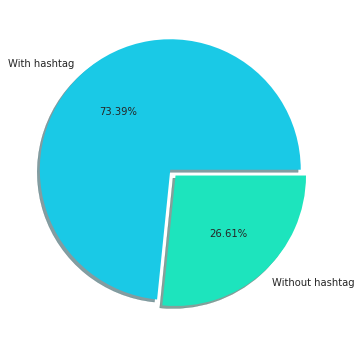

In [39]:
# Counts number of rows containing a hashtag
hashtag_tweet_count = count_rows_with_hashtag(train["tweet"])

train_rows, train_cols = train.shape

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    [hashtag_tweet_count, train_rows-hashtag_tweet_count],
    autopct = "%.2f%%",
    labels = ["With hashtag", "Without hashtag"],
    explode = [0, 0.06],
    shadow = True,
    colors = ["#1AC9E6", "#1DE4BD"]
)

plt.show()

* From our Pie chart, It is clear that most of the tweets contains a hashtag.
* These hashtags can help us classify the tweets more accurately.

# **Conclusion**

1. *The dataset contains three columns - "id", "label", "tweet".*
2. *Column "id" is not useful for classification.*
3. *Column "tweet" contains the tweets and column "label" contains their category.*
4. *There is no null values in the dataset.*
5. *Distribution of categories: 7.01 %  Offensive; 92.99 %  Not offensive.*
6. *Most of the tweets have around 5 to 20 tokens.*
7. *The number of tokens between 25th and 75th %ile (Interquartile range) of data ranges from 9 to 17 tokens, median being 13 tokens.* 
8. *Max length of any tweet in the dataset is less than 35 tokens.*
9. *We can see words like "racist", "black", "hate", "race" which are highly frequent in offensive tweets.*
10. *Most of the times tweets are about a specific person or an organisation.*
11. *Offensiveness in tweets mostly targets a specific person followed by organisations, religious, national or political parties.*
12. *Most frequent hashtags in Non-offensive tweets are "#love", "#positive", "#healthy", "#smile", "#thankful" which mostly reflects positivity.*
13. *Frequent hashtags in offensive tweets are "#black", "#hate", "#feminismiscancer", "#feminismisterrorism", "#hatred", "#race" which reflects offensiveness.*
14. *73.39 %  contains atleast one hashtag and only 26.61 %  does'nt contains a hashtag.*
15. *Hashtags can be helpful to improve model performance since they express what the tweet talks about most of the times.*